Usuniemy wartości które mogą zaburzać naukę algorytmu.

In [48]:
# Import bibliotek
# Podstawy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data split
from sklearn.model_selection import train_test_split

#ML
# ALGORYTMY
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# GridSearch i Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler

# Ocena
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve
from yellowbrick.classifier import ROCAUC
from mlxtend.plotting import plot_decision_regions

In [49]:
plt.rcParams["figure.figsize"] = (20,10)

In [50]:
db = pd.read_csv('dataset_5secondWindow%5B1%5D.csv')

In [51]:
db = db.rename(columns={"android.sensor.accelerometer#mean": "ASA_MEAN",
                   "android.sensor.accelerometer#min": "ASA_MIN",
                   "android.sensor.accelerometer#max": "ASA_MAX",
                   "android.sensor.accelerometer#std": "ASA_STD",
                   "android.sensor.gyroscope#mean": "ASG_MEAN",
                   "android.sensor.gyroscope#min": "ASG_MIN",
                   "android.sensor.gyroscope#max": "ASG_MAX",
                   "android.sensor.gyroscope#std": "ASG_STD",
                   "sound#mean": "SND_MEAN",
                   "sound#min": "SND_MIN",
                   "sound#max": "SND_MAX",
                   "sound#std": "SND_STD"}
          , errors="raise")

In [52]:
db['time'] = db['time'].astype(int)

Z tabeli usuwamy wartości powyżej 90 percentyla oraz identyczne wartości z kolumn ASG_MIN oraz ASG_MAX.

In [53]:
new_db = db.query('ASA_MIN < ASA_MIN.quantile(.90)')

In [54]:
new_db = new_db.query('ASG_MIN < ASG_MIN.quantile(.90)')

In [55]:
new_db = new_db.query('SND_MAX < SND_MAX.quantile(.90)')

In [56]:
new_db = db.query('ASG_MIN != ASG_MAX')

Tworzenie modelu

In [57]:
learning_data = new_db.copy()
learning_data['time'] = learning_data['time'].astype(int)
y = learning_data['target']
X = learning_data.drop(['target', 'SND_MIN', 'SND_MEAN'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [58]:
num_feat = X_train.columns

num_prep = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures()),
    ('scaler_1', StandardScaler())
])

data_prep = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_prep, num_feat)
])

In [59]:
def teach_and_check_scores(X_train, y_train, X_test, y_test, model):
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    preds_proba = model.predict_proba(X_test)    
    
    print(classification_report(y_test, preds))
    
    print(f'ROC AUC SCORE: {roc_auc_score(y_test, preds_proba, multi_class="ovr")}')

    plot_confusion_matrix(model, X_test, y_test, cmap='Blues')

In [60]:
knn_clf = Pipeline(steps=[('preprocessor', data_prep),
                          ('model', KNeighborsClassifier())])

In [61]:
params = {
    'model__n_neighbors': [3, 5, 7],
    'model__n_jobs': [-1, 200, 500, 1000],
    'model__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(knn_clf, params, cv=5, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
knn_v1 = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wybrane hiperparametry:  {'model__n_jobs': -1, 'model__n_neighbors': 3, 'model__weights': 'distance'}


              precision    recall  f1-score   support

         Bus       0.81      0.83      0.82       228
         Car       0.79      0.68      0.73       177
       Still       0.89      0.88      0.89       174
       Train       0.78      0.84      0.81       216
     Walking       0.90      0.93      0.92       180

    accuracy                           0.83       975
   macro avg       0.84      0.83      0.83       975
weighted avg       0.83      0.83      0.83       975

ROC AUC SCORE: 0.942226670593425


D:\PROGRAMMING\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


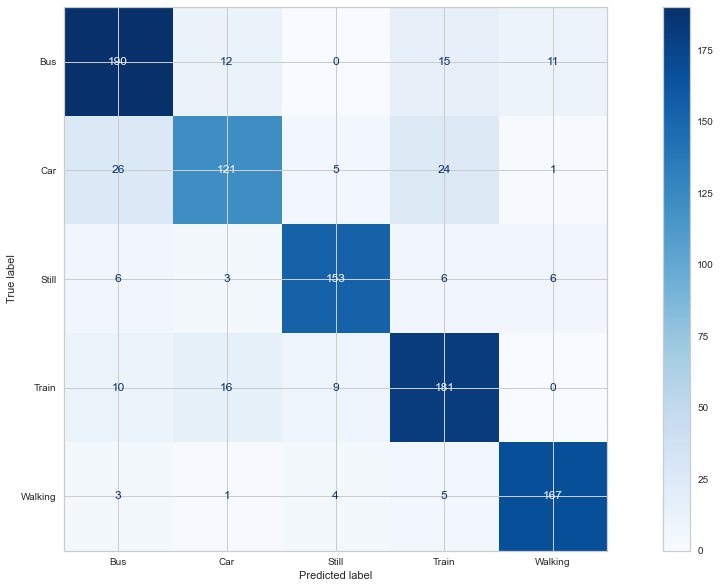

In [62]:
teach_and_check_scores(X_train, y_train, X_test, y_test, knn_v1)

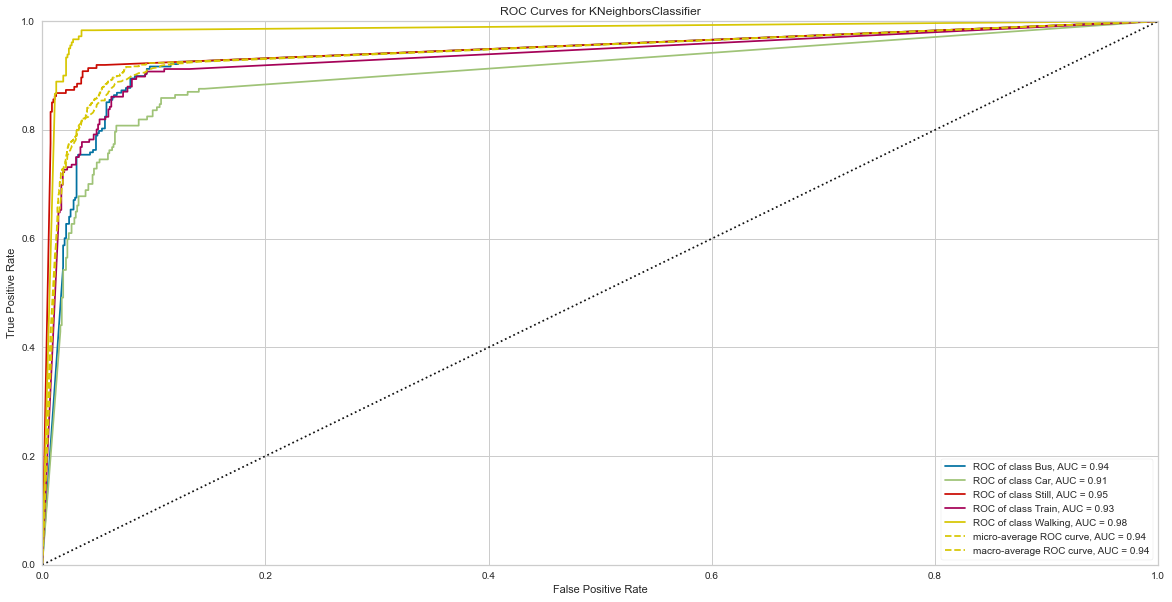

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
visualizer = ROCAUC(knn_v1, classes=np.unique(y_test))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

Wyniki są zadowalające. Możemy wykorzystać model przy produkcji asystenta wraz z opcją weryfikacji poprawności klasyfikacji przez samego użytkownika. Użytkownik zostanie zapytany po sklasyfikowaniu, czy algorytm zadziałał poprawnie.